### Importing important libraries

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

In [14]:
# Filter out the warnings.
import warnings
warnings.filterwarnings('ignore')

## Importing the dataset.

In [15]:
credit_df = pd.read_csv('MyCreditData.csv')
credit_df.head()

,checking_account,duration,credit_history,purpose,amount,savings_account,employment_duration,installment_rate,other_debtors,present_residence,...,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,gender,profit
0,3,18,0,2,1049,4,2,2,2,3,...,21,1,0,0,1,0,0,0,female,242
1,3,9,0,5,2799,4,0,1,2,0,...,36,1,0,1,1,1,0,0,male,596
2,0,12,4,8,841,0,1,1,2,3,...,23,1,0,0,3,0,0,0,female,25
3,3,12,0,5,2122,4,0,0,2,0,...,39,1,0,1,3,1,0,1,male,568
4,3,12,0,5,2171,4,0,2,2,3,...,38,0,2,1,3,0,0,1,male,782


### Categorical variables as Categorical datatype.

In [16]:
non_categorical_columns = ['duration', 'amount', 'age', 'profit']

for column in credit_df.columns:
    if column not in non_categorical_columns:
        credit_df[column] = pd.Categorical(credit_df[column])

# create binary dependent variable.
credit_df['is_profitable'] = np.where(credit_df['profit'] > 0, 1, 0)

In [17]:
y = credit_df['is_profitable']
X = credit_df.iloc[:, :-2] # All columns but the last two, profit and is_profitable.

In [18]:
# Use dummy variables for categorical variables.
X = pd.get_dummies(X, drop_first=False)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1)

In [19]:
# Scale the non-dummy variables.
scaler = StandardScaler()

X_train[['duration', 'amount', 'age']] = scaler.fit_transform(X_train[['duration', 'amount', 'age']])
X_val[['duration', 'amount', 'age']] = scaler.transform(X_val[['duration', 'amount', 'age']])

### Part 2 - Fitting a kNN model.

Our goal is to predict `is_profitable` using all available information, now using the k-Nearest Neighbors model (kNN).



#### 2.a: We use grid search to determine optimal value of $k$.

In [20]:
k_values = np.arange(1, 31)

# validation data accuracy numbers.
val_acc = []

for k in k_values:
    knn_clf = KNeighborsClassifier(n_neighbors=k)
    knn_clf.fit(X_train, y_train)
    y_pred = knn_clf.predict(X_val)
    val_acc.append(accuracy_score(y_val, y_pred))

#### Plotting the accuract score.

The maximum accuracy is at k=14


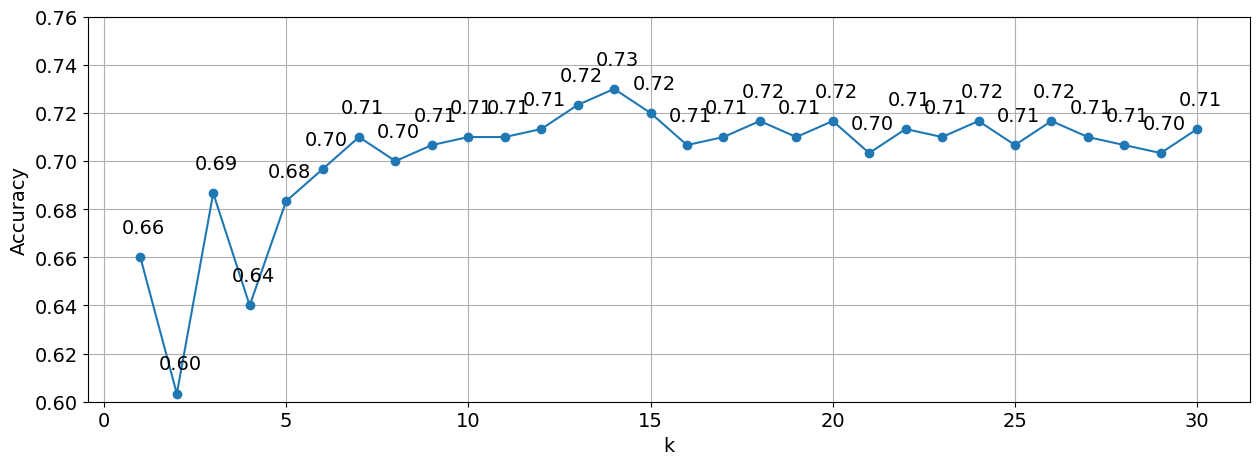

In [29]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure() 
ax = fig.add_subplot(111) 
ax.set_ylim(0.60,0.76) 
plt.plot(k_values,val_acc,marker='o') 
plt.xlabel("k")
plt.ylabel("Accuracy") 
plt.grid()
for i,j in zip(k_values,val_acc):
    ax.annotate('%.2f' % j,xy=(i-0.5,j+0.01))
    # print("The maximum accuracy is obtained at k = " + str(np.argmax(val_acc)+1))

print("The maximum accuracy is at k=" + str(np.argmax(val_acc)+1))
max_acc = np.argmax(val_acc)+1

In [34]:
knn_clf_best = KNeighborsClassifier(n_neighbors=max_acc)
knn_clf_best.fit(X_train, y_train)
y_pred = knn_clf_best.predict(X_val)

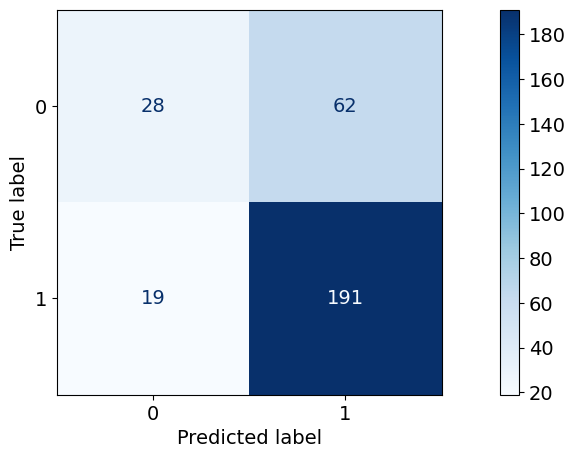

In [35]:
plt.rcParams.update({ 'font.size': 14 })
ConfusionMatrixDisplay.from_estimator(
    knn_clf_best,
    X_val,
    y_val,
    cmap=plt.cm.Blues,
)

### Model Metrics.

In [36]:
print("Validation data Accuracy Score: %.3f" % accuracy_score(y_val, y_pred))
print("Validation data F1 Score: %.3f" % f1_score(y_val, y_pred))
print("Validation data Sensitivity (recall of positive class): %.3f" % recall_score(y_val, y_pred, pos_label=1))
print("Validation data Specificity (recall of positive class): %.3f" % recall_score(y_val, y_pred, pos_label=0))

Validation data Accuracy Score: 0.730
Validation data F1 Score: 0.825
Validation data Sensitivity (recall of positive class): 0.910
Validation data Specificity (recall of positive class): 0.311


#### 2.b: We use vross-validation to determine optimal value of $k$.

In [39]:
knn_clf2 = KNeighborsClassifier()
param_grid = { 'n_neighbors': np.arange(1, 31) }

In [42]:
# specify the searchand find the best k.
grid = GridSearchCV(knn_clf2, param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose=1)
grid_search = grid.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [43]:
grid_search.best_params_

{'n_neighbors': 12}

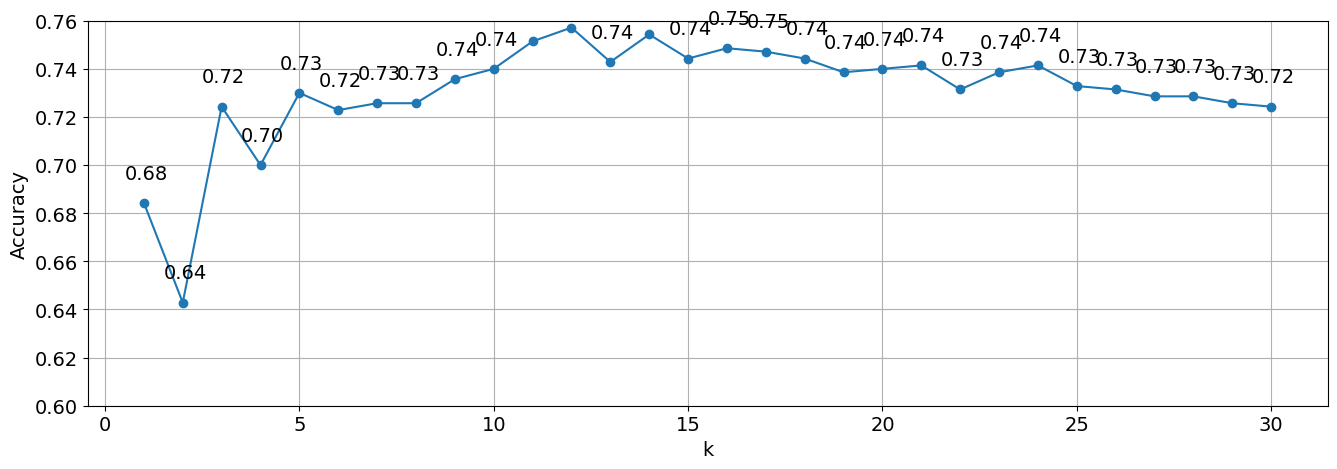

In [50]:
plt.rcParams['figure.figsize'] = [16, 5]
fig = plt.figure() 
ax = fig.add_subplot(111) 
ax.set_ylim(0.60,0.76) 
plt.plot(param_grid['n_neighbors'], grid_search.cv_results_['mean_test_score'],marker='o') 
plt.xlabel("k")
plt.ylabel("Accuracy") 
plt.grid()
for i,j in zip(param_grid['n_neighbors'],grid_search.cv_results_['mean_test_score']):
    ax.annotate('%.2f' % j,xy=(i-0.5,j+0.01))
    # print("The maximum accuracy is obtained at k = " + str(np.argmax(val_acc)+1))

In [52]:
knn_clf_best = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'])
knn_clf_best.fit(X_train, y_train)
y_pred = knn_clf_best.predict(X_val)

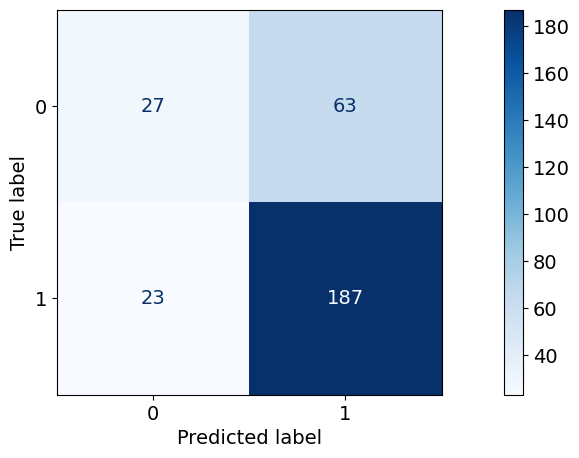

In [53]:
plt.rcParams.update({ 'font.size': 14 })
ConfusionMatrixDisplay.from_estimator(
    knn_clf_best,
    X_val,
    y_val,
    cmap=plt.cm.Blues,
)

In [54]:
print("Validation data Accuracy Score: %.3f" % accuracy_score(y_val, y_pred))
print("Validation data F1 Score: %.3f" % f1_score(y_val, y_pred))
print("Validation data Sensitivity (recall of positive class): %.3f" % recall_score(y_val, y_pred, pos_label=1))
print("Validation data Specificity (recall of positive class): %.3f" % recall_score(y_val, y_pred, pos_label=0))

Validation data Accuracy Score: 0.713
Validation data F1 Score: 0.813
Validation data Sensitivity (recall of positive class): 0.890
Validation data Specificity (recall of positive class): 0.300


### 3: Building kNN for prediction.

In [55]:
y = credit_df['profit']
y_train, y_val = train_test_split(y, test_size=0.3, random_state = 1)

In [56]:
# rmse function
def rmse(y_train, y_pred):
    return np.sqrt(mean_squared_error(y_train, y_pred))

In [63]:
k_values = np.arange(1, 31)

# validation data accuracy numbers.
val_rmse = []

for k in k_values:
    knn_reg = KNeighborsRegressor(n_neighbors=k)
    knn_reg.fit(X_train, y_train)
    y_pred = knn_reg.predict(X_val)
    val_rmse.append(rmse(y_val, y_pred))

In [64]:
val_rmse

[1627.1332418295272,
 1500.6612642432003,
 1284.2551113821237,
 1289.4062935287957,
 1246.590707757228,
 1224.1753535732928,
 1213.1987316383822,
 1209.3550082757613,
 1214.763330723636,
 1196.0431833898529,
 1206.999976468762,
 1194.4793997630654,
 1193.8985670988595,
 1188.786183051269,
 1186.8650813772358,
 1195.489710937879,
 1192.3009148472374,
 1187.3960878512462,
 1181.1235972049762,
 1176.5838236358968,
 1169.7257074029512,
 1169.2305483314722,
 1171.285594921591,
 1175.672245691032,
 1176.8304993894972,
 1171.3239769253073,
 1164.582899694406,
 1159.9447103254124,
 1157.03491275678,
 1161.2491073568312]

#### Plotting the accuract score.

The minimum rmse is at k=29


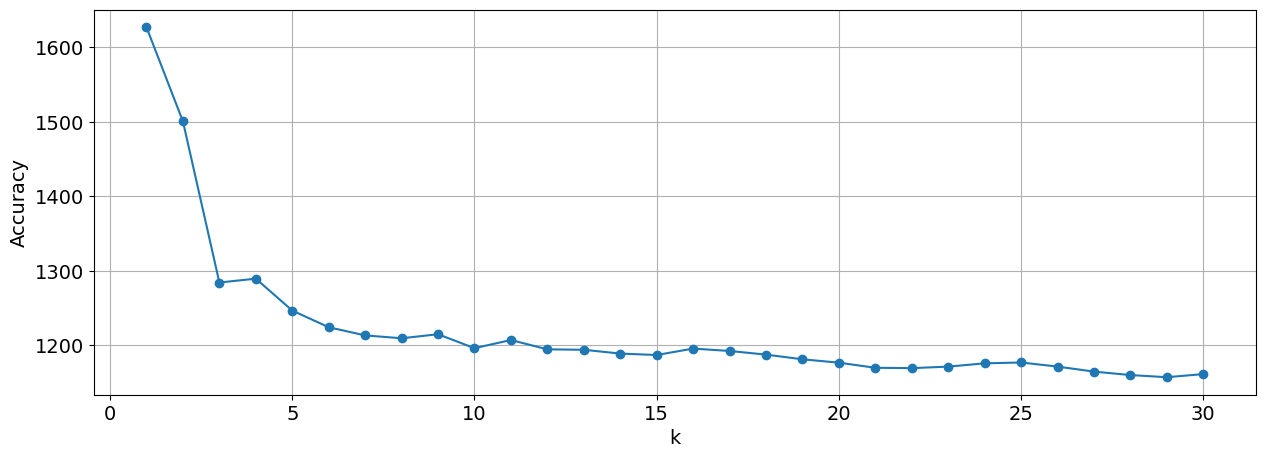

In [78]:
plt.plot(k_values,val_rmse,marker='o') 
plt.xlabel("k")
plt.ylabel("Accuracy") 
plt.grid()

print("The minimum rmse is at k=" + str(np.argmin(val_rmse)+1))
min_rmse = np.argmin(val_rmse)+1

In [79]:
knn_reg_best = KNeighborsRegressor(n_neighbors=min_rmse)
knn_reg_best.fit(X_train, y_train)
y_pred = knn_reg_best.predict(X_val)
print('RMSE validation set:', round(rmse(y_val, y_pred), 2))

RMSE validation set: 1157.03


#### Grid search

In [80]:
knn_reg2 = KNeighborsRegressor()
param_grid = { 'n_neighbors': np.arange(1, 31) }

In [81]:
# specify the searchand find the best k.
grid = GridSearchCV(knn_reg2, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, verbose=1)
grid_search = grid.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [82]:
grid_search.best_params_

{'n_neighbors': 16}

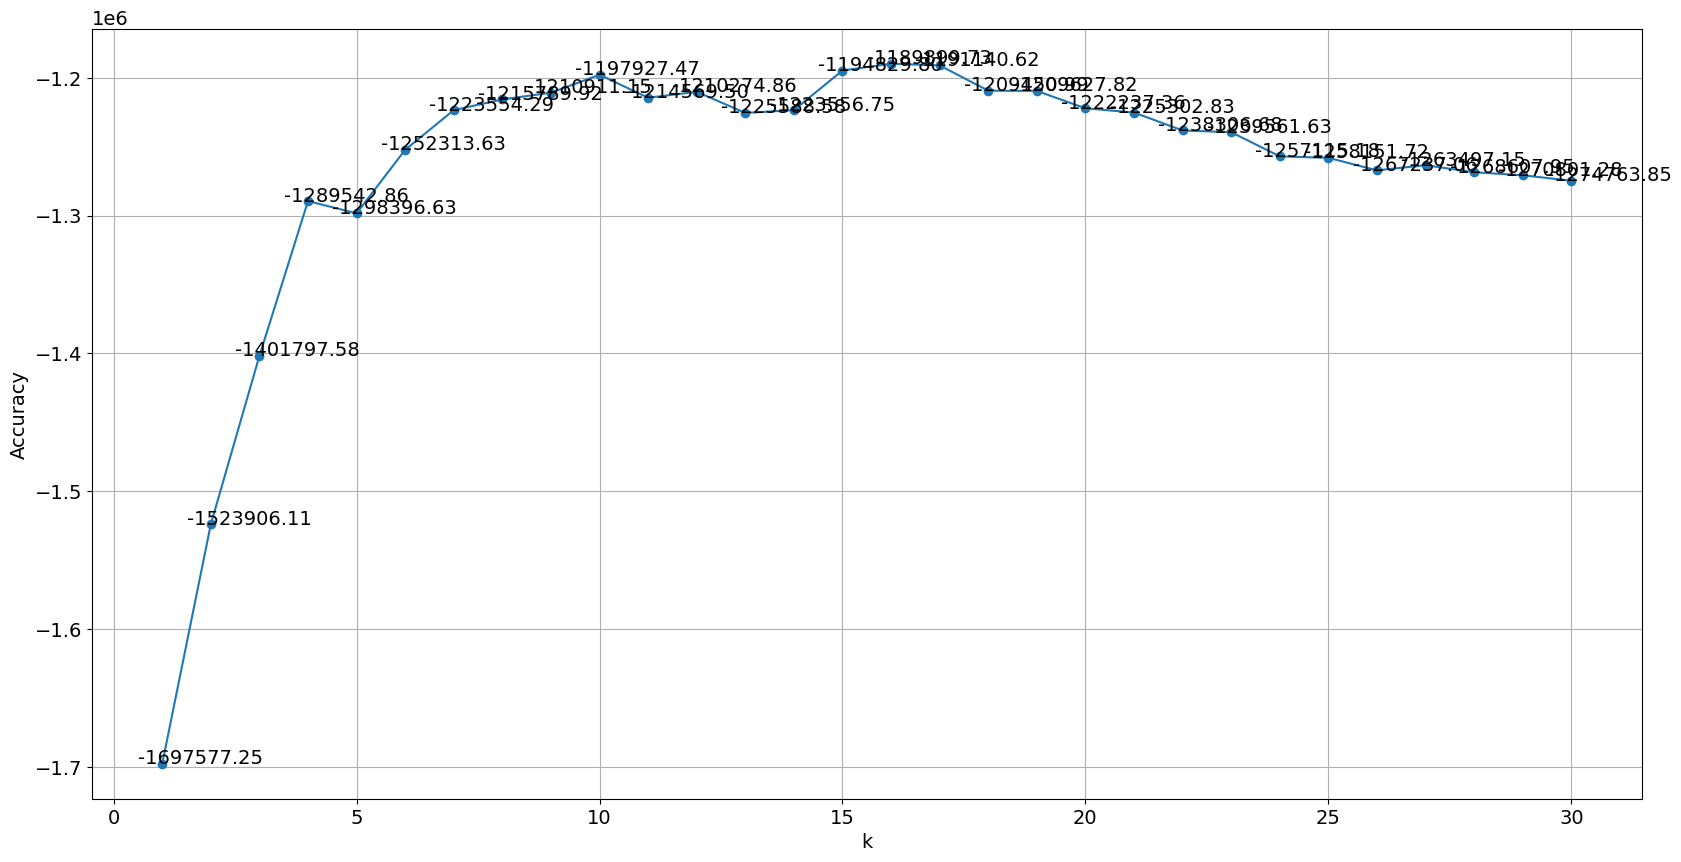

In [86]:
plt.rcParams['figure.figsize'] = [20, 10]
fig = plt.figure() 
ax = fig.add_subplot(111) 
plt.plot(param_grid['n_neighbors'], grid_search.cv_results_['mean_test_score'],marker='o') 
plt.xlabel("k")
plt.ylabel("Accuracy") 
plt.grid()
for i,j in zip(param_grid['n_neighbors'],grid_search.cv_results_['mean_test_score']):
    ax.annotate('%.2f' % j,xy=(i-0.5,j+0.01))
    # print("The maximum accuracy is obtained at k = " + str(np.argmax(val_acc)+1))

In [89]:
print("The best value of k is: ", str(np.argmax(grid_search.cv_results_['mean_test_score']+1)))

The best value of k is:  15


In [90]:
knn_reg_best = KNeighborsRegressor(n_neighbors=grid_search.best_params_['n_neighbors'])
knn_reg_best.fit(X_train, y_train)
y_pred = knn_reg_best.predict(X_val)

In [91]:
print("RMSE on the validation data: ", round(rmse(y_val, y_pred), 2))

RMSE on the validation data:  1195.49
